Name: Diran Suraj

PI: Z7279378

# Kvasir Dataset Classifications 

## Setup

In [1]:
import tensorflow as tf, keras
import numpy as np

import os
import json
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import Sequential, optimizers
from keras.applications import *
from tensorflow.keras.layers import *
from keras.models import Model
import tensorflow_datasets as tfds

## Available dataset 

In [2]:
data_dir = '/datasets/kvasir'

### Define some constants

In [3]:
# Constants
IMAGE_RESCALE = (224, 224)
input_shape = (IMAGE_RESCALE[0], IMAGE_RESCALE[1], 3)
batch_size = 32

In [4]:
encoder_vocab_file = os.path.join(data_dir, 'labels.txt')
label_encoder = StringLookup(vocabulary=encoder_vocab_file, num_oov_indices=0, output_mode='one_hot')

num_classes = len(label_encoder.get_vocabulary())

label_lookup = {i: n for i, n in enumerate(label_encoder.get_vocabulary())}
label_lookup

{0: 'dyed-lifted-polyps',
 1: 'dyed-resection-margins',
 2: 'esophagitis',
 3: 'normal-cecum',
 4: 'normal-pylorus',
 5: 'normal-z-line',
 6: 'polyps',
 7: 'ulcerative-colitis'}

### Creating  training, validation, and testing subdatasets

We have already split the data into training, validation, and testing datasets.

In [5]:
# Adjusted load_image function to accept file_path and label separately
def load_image(file_path, label):
    # read the image from disk, decode it, resize it, and scale the pixels intensities to the range [0, 1]
    image = tf.io.read_file(file_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.resize(image, IMAGE_RESCALE)
    image /= 255.0
    # grab the label and encode it
    encoded_label = label_encoder(label)
    
    # return the image and the one-hot encoded label
    return image, encoded_label

In [6]:
train_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'train_set.csv'), batch_size=batch_size, num_epochs=1)
train_file_labels = train_file_labels.unbatch()

In [7]:
validation_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'val_set.csv'), batch_size=batch_size, num_epochs=1)
validation_file_labels = validation_file_labels.unbatch()

In [8]:
test_file_labels = tf.data.experimental.make_csv_dataset(
    os.path.join(data_dir, 'test_set.csv'), batch_size=batch_size, num_epochs=1)
test_file_labels = test_file_labels.unbatch()

In [9]:
train_dataset = train_file_labels.map(lambda fl: (fl['file_name'], fl['class']), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000)
train_dataset = train_dataset.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

In [10]:
val_dataset = validation_file_labels.map(lambda fl: (fl['file_name'], fl['class']), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [11]:
test_dataset = test_file_labels.map(lambda fl: (fl['file_name'], fl['class']), 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.map(load_image, 
                                      num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

### Ploting the distribution of the classes in the data

In [12]:
counts = train_file_labels.map(lambda fl: label_encoder(fl['class']))
counts = counts.reduce(tf.zeros((num_classes,), dtype=tf.int64),
                             lambda o, l: tf.math.add(o, l))
counts

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([365, 361, 344, 349, 353, 342, 344, 342])>

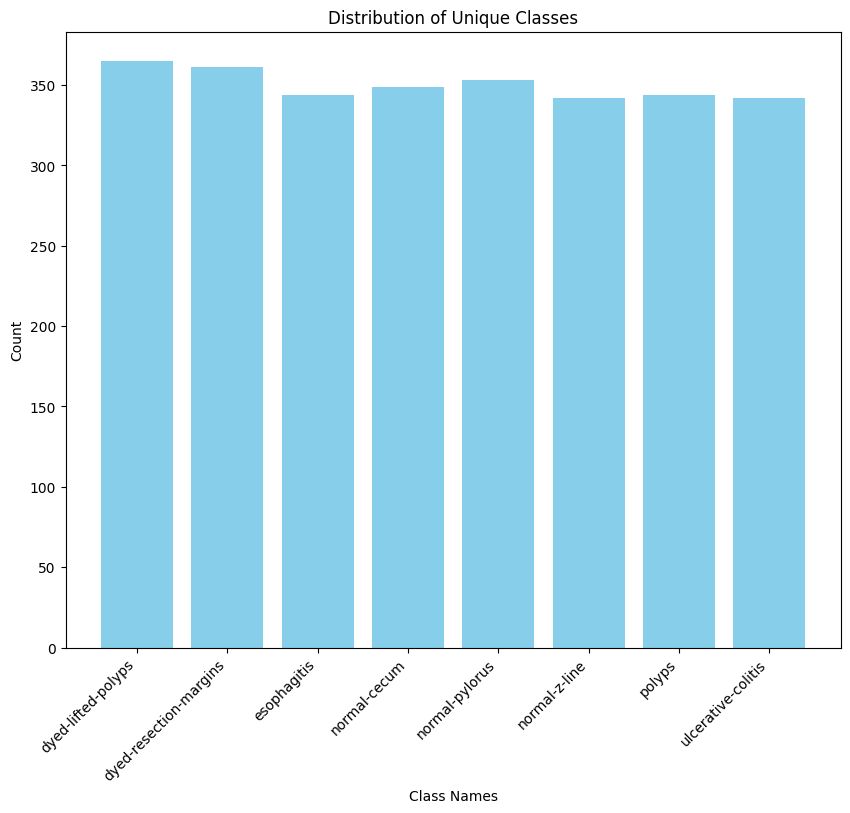

In [13]:
# Plot distribution using class names
plt.figure(figsize=(10, 8))
plt.bar(label_encoder.get_vocabulary(), counts.numpy(), color='skyblue')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Distribution of Unique Classes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plotted distribution

Based on this specific bar chart, the dataset appears to be relatively balanced. All eight classes have a similar number of images, with counts ranging roughly between 340 and 370.

In [15]:
# Get test data counts per class
test_counts = test_file_labels.map(lambda fl: label_encoder(fl['class']))
test_counts = test_counts.reduce(tf.zeros((num_classes,), dtype=tf.int64),
                                 lambda o, l: tf.math.add(o, l))

test_counts

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([ 83, 102, 106,  97,  97, 107, 108, 100])>

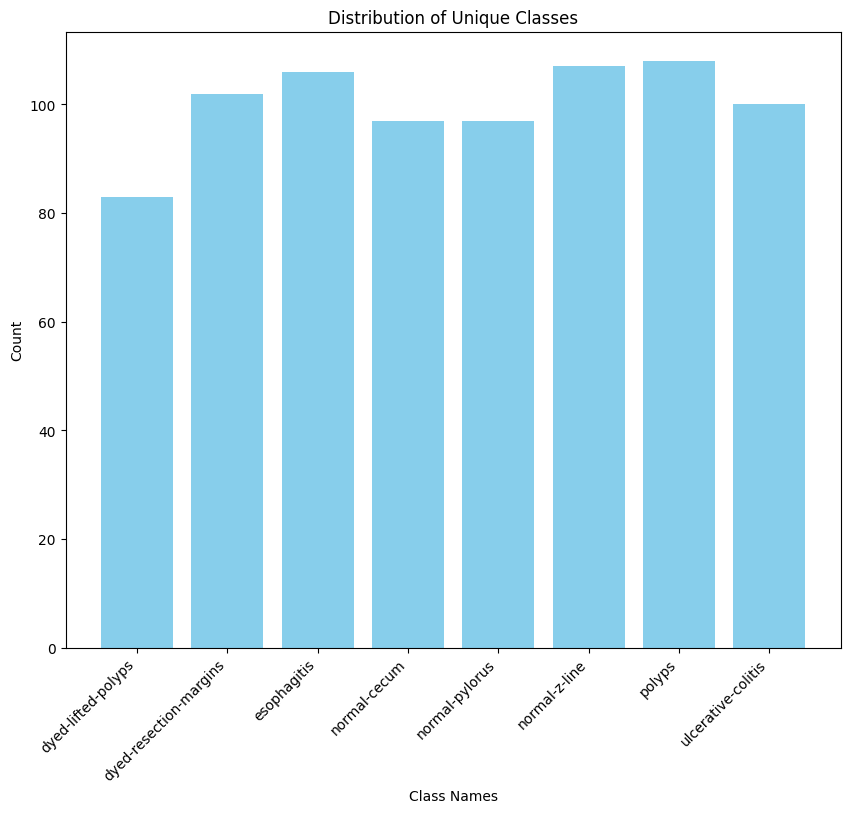

In [16]:
# Plot distribution using class names
plt.figure(figsize=(10, 8))
plt.bar(label_encoder.get_vocabulary(), test_counts.numpy(), color='skyblue')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Distribution of Unique Classes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plotted distribution

In [18]:
# Get validation data counts per class
val_counts = validation_file_labels.map(lambda fl: label_encoder(fl['class']))
val_counts = val_counts.reduce(tf.zeros((num_classes,), dtype=tf.int64),
                                lambda o, l: tf.math.add(o, l))

val_counts

<tf.Tensor: shape=(8,), dtype=int64, numpy=array([52, 37, 50, 54, 50, 51, 48, 58])>

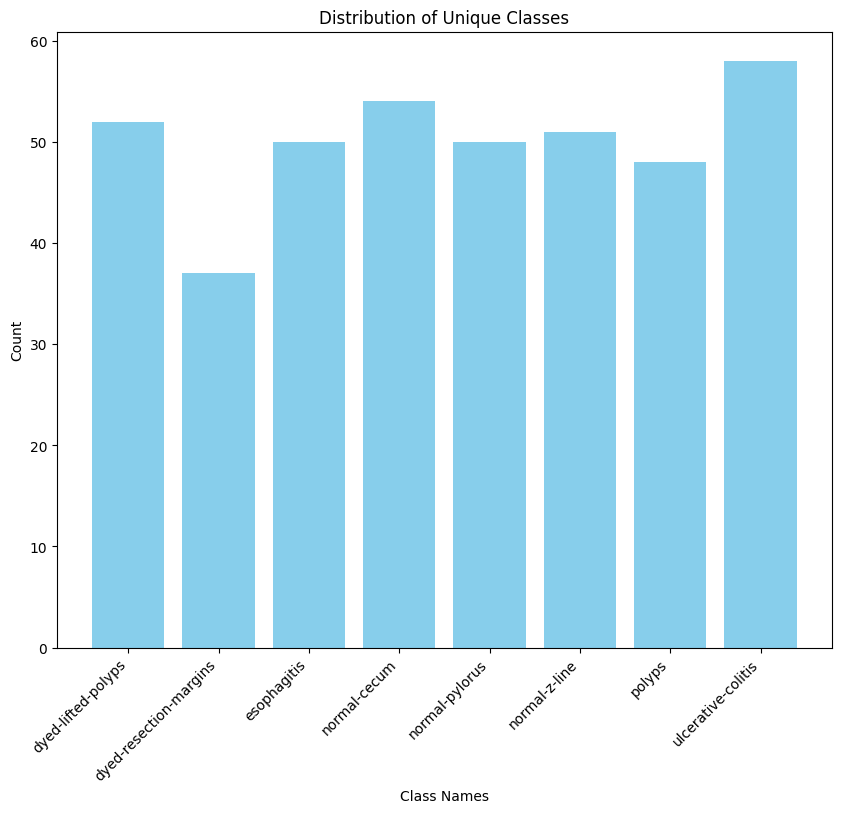

In [19]:
# Plot distribution using class names
plt.figure(figsize=(10, 8))
plt.bar(label_encoder.get_vocabulary(), val_counts.numpy(), color='skyblue')
plt.xlabel("Class Names")
plt.ylabel("Count")
plt.title("Distribution of Unique Classes")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.show()  # Display the plotted distribution

### Examining some sample data

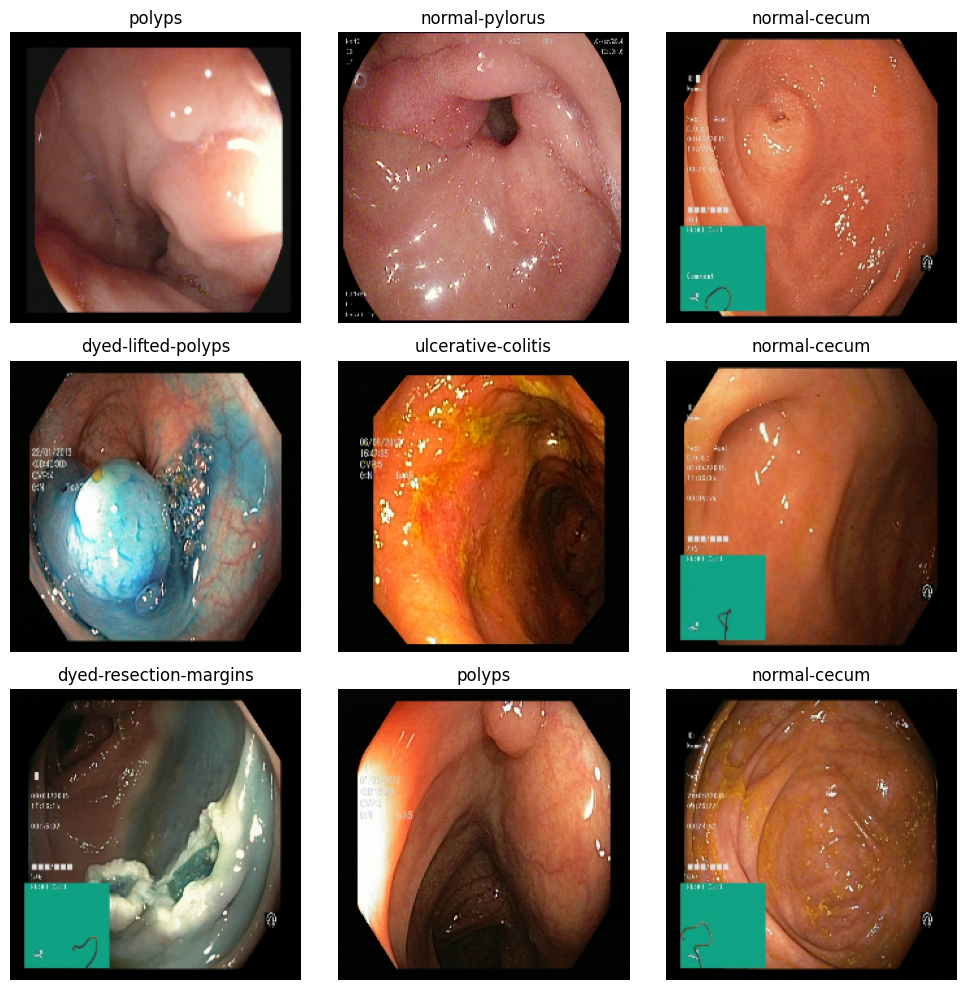

In [81]:
# Fetch a batch of images and labels from the dataset
sample_images, sample_labels = next(iter(train_dataset))

sample_images = (sample_images * 255).numpy().astype("uint8")  # Scale to [0, 255]

# Plot the images with labels
plt.figure(figsize=(10, 10))
for i in range(min(9, len(sample_images))):  # Display up to 9 images or the total number in the batch
    ax = plt.subplot(3, 3, i + 1)

    # Extract and map the label
    label_index = np.argmax(sample_labels[i])  # If one-hot encoded
    class_name = label_lookup[label_index]
    
    # Display the image and its label
    plt.imshow(sample_images[i])
    plt.title(class_name)
    plt.axis("off")  # Turn off axes for better visual clarity

plt.tight_layout()
plt.show()

# Create and train baseline model

In [25]:
model_0 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

In [26]:
opt = optimizers.Adam(learning_rate=1e-4)

model_0.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [27]:
history = model_0.fit(
    train_dataset,  
    epochs=20,
    validation_data=val_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)]
)

Epoch 1/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 21s 177ms/step - accuracy: 0.4710 - loss: 1.9289 - precision_1: 0.5079 - recall_1: 0.4120 - val_accuracy: 0.2625 - val_loss: 3.0664 - val_precision_1: 0.3806 - val_recall_1: 0.2350
Epoch 2/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.6173 - loss: 0.9153 - precision_1: 0.6914 - recall_1: 0.5457 - val_accuracy: 0.3850 - val_loss: 2.4892 - val_precision_1: 0.4737 - val_recall_1: 0.3375
Epoch 3/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.6766 - loss: 0.7790 - precision_1: 0.7288 - recall_1: 0.6242 - val_accuracy: 0.5175 - val_loss: 2.2117 - val_precision_1: 0.6117 - val_recall_1: 0.4450
Epoch 4/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - accuracy: 0.7203 - loss: 0.6587 - precision_1: 0.7708 - recall_1: 0.6664 - val_accuracy: 0.5400 - val_loss: 1.4461 - val_precision_1: 0.5843 - val_recall_1: 0.5200
Epoch 5/20
88/88 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.7095 - loss: 0.6184 - precision_1: 0.7516 - recall_1: 0.6633

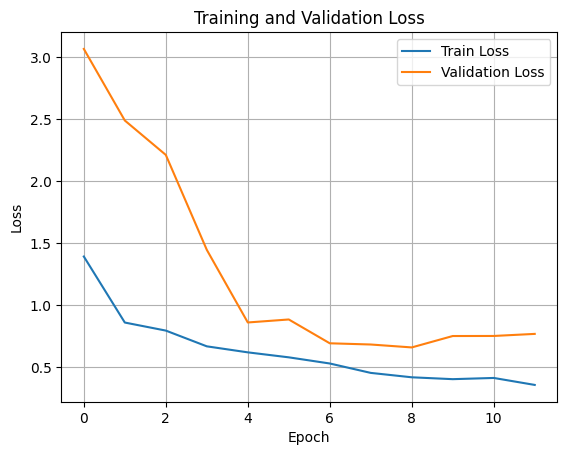

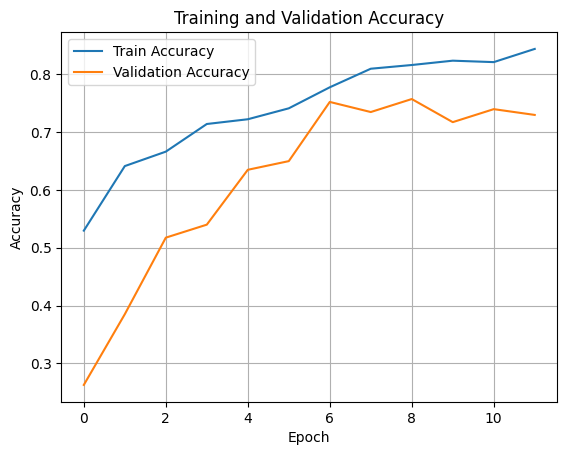

In [28]:
# Assuming history contains the training history returned by model.fit
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
model_0.save('baseline_model.keras')

with open('baseline_model_history.json', 'w') as f:
    json.dump(history.history, f)

In [30]:
model = tf.keras.models.load_model('baseline_model.keras')

with open('baseline_model_history.json') as f:
    baseline_history = json.load(f)

### Evaluating the model

In [31]:
model_0.evaluate(test_dataset, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.7709 - loss: 0.5576 - precision_1: 0.7798 - recall_1: 0.7604


{'accuracy': 0.7450000047683716,
 'loss': 0.6589962244033813,
 'precision_1': 0.7509578466415405,
 'recall_1': 0.7350000143051147}

Performance Metrics:

Accuracy (74.5%):
Excellent for a baseline, well above the 50-60% target and competitive with simpler transfer learning models. Provides a strong reference for VGG16, ResNet50, and InceptionV3.
Loss (0.659):
Reasonable, though the plot shows a higher validation loss (~0.9) at the end, suggesting the reported loss is from the best epoch.
Precision (75.1%) and Recall (73.5%):
Precision is stable, and the recall improvement is significant for a medical task.
However, recall is  below the ideal >80% for clinical reliability, especially for critical classes like polyps.

Generalization (Overfitting)
Current: Train accuracy 0.8, validation 0.72 (~8% gap); train loss 0.5, validation 0.9.

Remaining Issue: Overfitting persists, though it’s less severe. Validation accuracy plateaus at ~0.72-0.75, indicating the model struggles to generalize further.

This is now a very good baseline model. The 74.5% accuracy and improved recall (73.5%) make it a strong reference point for transfer learning models. Overfitting is still a concern, but the addition of data augmentation has improved generalization, making the model more reliable than the previous iteration.

# Enhancements

## Enhancement 1 - General Improvements

general improvements for a more robust and generalizable model:

- Batch Normalization: For more stable and faster training.
- GlobalAveragePooling2D: To reduce overfitting and encourage learning of more global and spatially invariant features.
- Increased Epochs (20 to 50): To allow more learning opportunities given the more stable training and better generalization potential.
- Increased Patience (3 to 7): To allow the training process more flexibility and avoid premature stopping.

In [29]:
model_1 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    BatchNormalization(),  
    MaxPooling2D(2),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),  
    MaxPooling2D(2),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(2),
    GlobalAveragePooling2D(), 
    Dense(128, activation='relu'),
    Dropout(0.5),  
    Dense(8, activation='softmax')
])

In [30]:
opt = optimizers.Adam(learning_rate=1e-4)

model_1.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [31]:
history_1 = model_1.fit(
    train_dataset,  
    epochs=50,
    validation_data=val_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)]
)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 153ms/step - accuracy: 0.2716 - loss: 1.8861 - precision_2: 0.3355 - recall_2: 0.0105 - val_accuracy: 0.1250 - val_loss: 2.0869 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.4351 - loss: 1.3780 - precision_2: 0.5622 - recall_2: 0.1070 - val_accuracy: 0.1250 - val_loss: 2.0965 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.5142 - loss: 1.1982 - precision_2: 0.6366 - recall_2: 0.2100 - val_accuracy: 0.1375 - val_loss: 2.0818 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5303 - loss: 1.1166 - precision_2: 0.6231 - recall_2: 0.2582 - val_accuracy: 0.1875 - val_loss: 1.9391 - val_precision_2: 0.5000 - val_recall_2: 0.0025
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5535 - loss: 1.0481 - precision_2: 0.6215

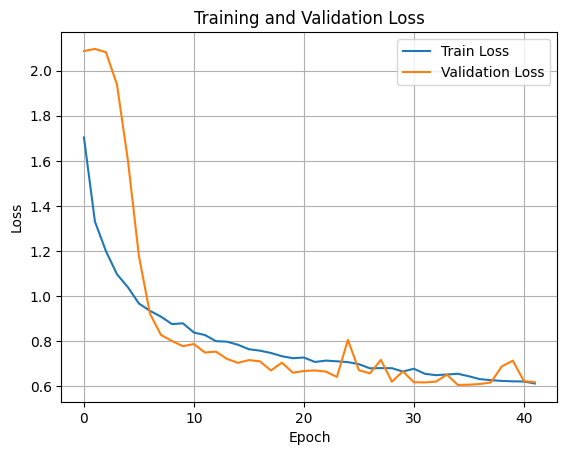

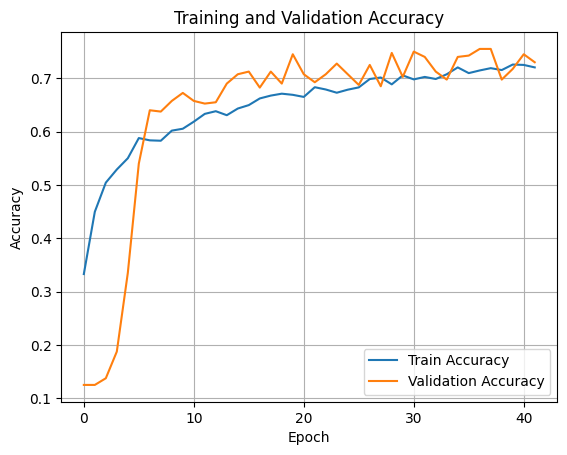

In [32]:
# Assuming history contains the training history returned by model.fit
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
train_acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
model_1.save('model_1.keras')

with open('model_1_history.json', 'w') as f:
    json.dump(history_1.history, f)

In [34]:
model = tf.keras.models.load_model('model_1.keras')

with open('model_1_history.json') as f:
    model_1_history = json.load(f)

In [35]:
# Evaluate the model on the test set
test_results = model_1.evaluate(test_dataset, return_dict=True)
print("Test Set Evaluation Results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.7220 - loss: 0.6089 - precision_2: 0.7414 - recall_2: 0.6853
Test Set Evaluation Results:
accuracy: 0.7275000214576721
loss: 0.603299081325531
precision_2: 0.7496635317802429
recall_2: 0.6962500214576721


Reduced Overfitting Compared to model_0. model_1 exhibits less pronounced overfitting. The divergence between the training and validation loss and accuracy is smaller. This could be attributed to the use of GlobalAveragePooling2D instead of Flatten, which reduces the number of trainable parameters in the fully connected layers, thus reducing the model's capacity to memorize the training data.

Signs of Stagnation: While overfitting is less severe, the validation loss and accuracy seem to have plateaued after around 20-30 epochs. This suggests that the model might have reached its learning capacity for the given architecture and hyperparameters on this dataset. Further training beyond this point doesn't seem to significantly improve generalization.

Accuracy: The updated model (model_1) has a slightly lower accuracy (72.8%) compared to the baseline model (model_0) (74.5%) on the test set.

Loss: The updated model (model_1) has a lower loss (0.603) on the test set compared to the baseline (0.659). This generally suggests that the model's predictions are closer to the true values in terms of the loss function.

Precision: The precision is very similar for both models (around 75%). This means that when both models predict a positive class, they are correct a similar percentage of the time.

Recall: The updated model (model_1) has a noticeably lower recall (69.6%) compared to the baseline (73.5%). This means that the updated model is correctly identifying fewer of the actual positive instances in the test set compared to the baseline.

## Enhancement 2 - Increasing Complexity

Goal: Increase the model’s capacity to capture more complex features (e.g., mucosal patterns in ulcerative colitis) while managing underfitting.

Simple Implementation: Add one more Conv2D layer with 128 filters to deepen the model, maintaining batch normalization for stability. Reduced dropout rate from 0.5 to 0.4 to mitigate underfitting

Why: The current model has only 3 convolutional layers, which may limit its ability to learn hierarchical features. Adding a layer increases capacity without excessive complexity.

In [19]:
model_2 = Sequential([
    Input(shape=(224, 224, 3)),
    Conv2D(16, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(32, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(64, 3, activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(2),
    Conv2D(128, 3, activation='relu', padding='same'),  # Added layer
    BatchNormalization(),
    MaxPooling2D(2),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),  # Reduced to 0.4 to mitigate underfitting
    Dense(8, activation='softmax')
])

In [20]:
opt = optimizers.Adam(learning_rate=1e-4)

model_2.compile(optimizer=opt,
                loss='categorical_crossentropy',
                metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [21]:
history_2 = model_2.fit(
    train_dataset,  
    epochs=50,
    validation_data=val_dataset,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)]
)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 19s 151ms/step - accuracy: 0.3037 - loss: 1.7444 - precision_1: 0.3865 - recall_1: 0.0684 - val_accuracy: 0.0925 - val_loss: 2.1110 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.5441 - loss: 1.0793 - precision_1: 0.6532 - recall_1: 0.3368 - val_accuracy: 0.0925 - val_loss: 2.1058 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.5865 - loss: 0.9474 - precision_1: 0.6537 - recall_1: 0.4410 - val_accuracy: 0.2300 - val_loss: 1.9686 - val_precision_1: 0.5667 - val_recall_1: 0.0425
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.6226 - loss: 0.8572 - precision_1: 0.6824 - recall_1: 0.4946 - val_accuracy: 0.3300 - val_loss: 1.6477 - val_precision_1: 0.4868 - val_recall_1: 0.0925
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 9s 104ms/step - accuracy: 0.6427 - loss: 0.8238 - precision_1: 0.6889 - r

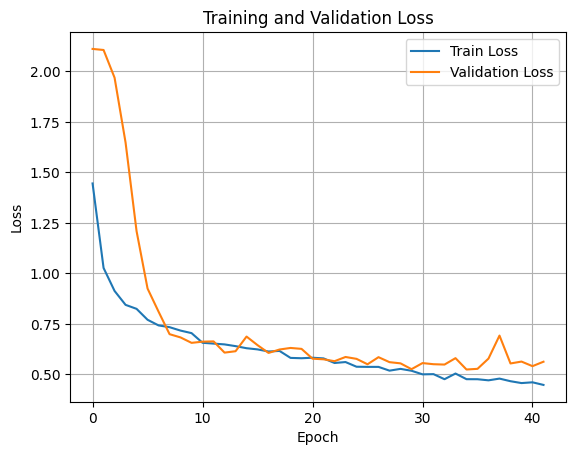

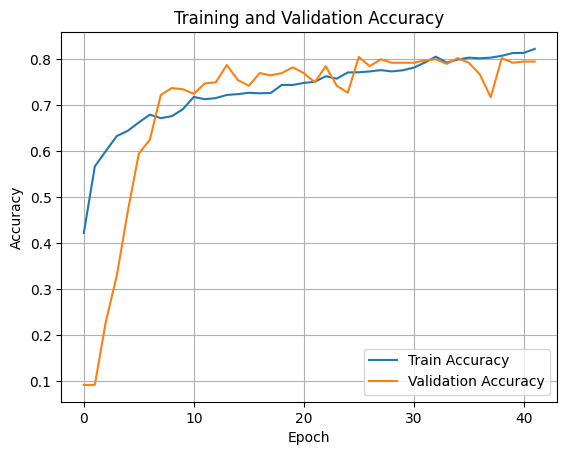

In [22]:
# Assuming history contains the training history returned by model.fit
train_loss = history_2.history['loss']
val_loss = history_2.history['val_loss']
train_acc = history_2.history['accuracy']
val_acc = history_2.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
model_2.save('model_2.keras')

with open('model_2_history.json', 'w') as f:
    json.dump(history_2.history, f)

model = tf.keras.models.load_model('model_2.keras')

with open('model_2_history.json') as f:
    model_2_history = json.load(f)

In [24]:
# Evaluate the model on the test set
test_results = model_2.evaluate(test_dataset, return_dict=True)
print("Test Set Evaluation Results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.8199 - loss: 0.4709 - precision_1: 0.8299 - recall_1: 0.8115
Test Set Evaluation Results:
accuracy: 0.7887499928474426
loss: 0.5037487149238586
precision_1: 0.8059508204460144
recall_1: 0.7787500023841858


Accuracy: 0.789 (or 78.9%) - The model correctly classified 78.9% of the samples in the test set. This is an improvement over both the baseline (model_0: 74.5%) and the previous model (model_1: 72.8%).

Loss: 0.504 - The loss on the test set is the lowest among the three models (model_0: 0.659, model_1: 0.603). This indicates that the model's predictions are, on average, closer to the true values according to the loss function.

Precision: 0.806 (or 80.6%) - The precision is the highest among the three models (model_0: 0.751, model_1: 0.750). This means that when model_2 predicts a positive class, it is more likely to be correct.

Recall: 0.779 (or 77.9%) - The recall is also the highest among the three models (model_0: 0.735, model_1: 0.696). This indicates that model_2 is better at correctly identifying the actual positive instances in the test set.

Improved Performance: model_2 shows a clear improvement in generalization to the unseen test data compared to the previous models.

Well-Behaved Training: The training and validation curves indicate a good learning process without significant overfitting. The validation loss and accuracy track the training loss and accuracy reasonably well. The plateauing of validation metrics suggests that the model has learned effectively for the given architecture and training duration.

Effective Modifications: The addition of a convolutional layer and the slight adjustment of the dropout rate appear to have been beneficial in enhancing the model's ability to learn and generalize.

The more complex model significantly improved recall (77.88%), suggesting that deeper feature extraction is key for this task. Residual links build on this by improving gradient flow, potentially pushing recall above 80%, which is critical for clinical reliability.

## Enhancement 3 - Residual links

In [16]:
from tensorflow.keras.layers import Add

inputs = Input(shape=(224, 224, 3))
x = Conv2D(16, 3, activation='relu', padding='same')(inputs)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2)(x)
residual = Conv2D(128, 1, padding='same')(x)  # 1x1 Conv to match dimensions
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Add()([x, residual])  # Skip connection
x = MaxPooling2D(2)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
outputs = Dense(8, activation='softmax')(x)
model_3 = tf.keras.Model(inputs, outputs)

# Compile and train
opt = optimizers.Adam(learning_rate=1e-4)
model_3.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
history_3 = model_3.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[tf.keras.callbacks.EarlyStopping(patience=7, restore_best_weights=True)])

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 17s 135ms/step - accuracy: 0.2796 - loss: 1.9494 - precision_1: 0.3847 - recall_1: 0.0941 - val_accuracy: 0.2100 - val_loss: 2.0742 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5278 - loss: 1.0743 - precision_1: 0.6016 - recall_1: 0.3214 - val_accuracy: 0.1275 - val_loss: 2.1056 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.5908 - loss: 0.9540 - precision_1: 0.6705 - recall_1: 0.4340 - val_accuracy: 0.1475 - val_loss: 2.0078 - val_precision_1: 0.3523 - val_recall_1: 0.0775
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.6144 - loss: 0.8686 - precision_1: 0.6679 - recall_1: 0.4945 - val_accuracy: 0.3325 - val_loss: 1.5349 - val_precision_1: 0.6739 - val_recall_1: 0.1550
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.6390 - loss: 0.8235 - precision_1: 0.6803 - recal

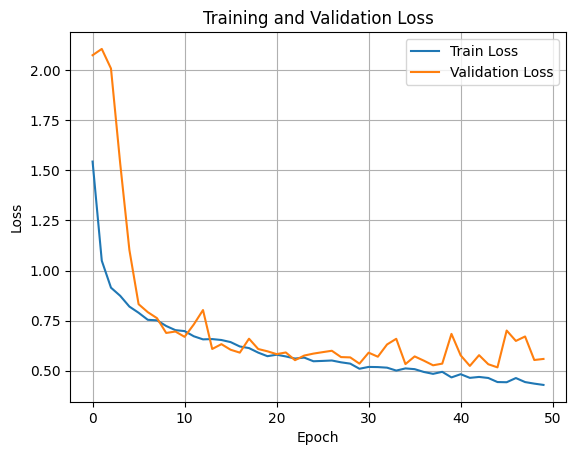

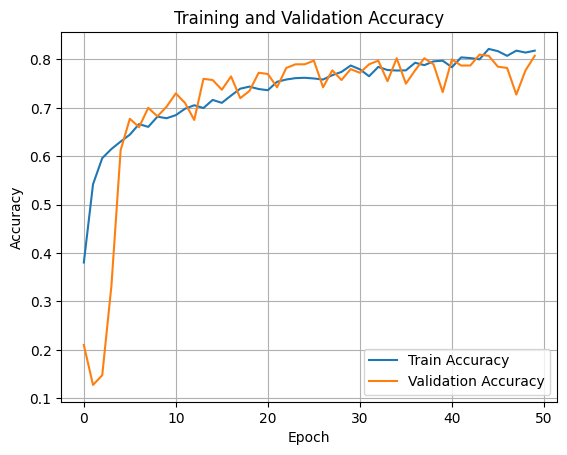

In [17]:
# Assuming history contains the training history returned by model.fit
train_loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
train_acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
model_3.save('model_3.keras')

with open('model_3_history.json', 'w') as f:
    json.dump(history_3.history, f)

model = tf.keras.models.load_model('model_3.keras')

with open('model_3_history.json') as f:
    model_3_history = json.load(f)

In [19]:
# Evaluate the model on the test set
test_results = model_3.evaluate(test_dataset, return_dict=True)
print("Test Set Evaluation Results:")
for metric, value in test_results.items():
    print(f"{metric}: {value}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7828 - loss: 0.5212 - precision_1: 0.7908 - recall_1: 0.7767
Test Set Evaluation Results:
accuracy: 0.800000011920929
loss: 0.49868637323379517
precision_1: 0.811779797077179
recall_1: 0.7925000190734863


The model exhibits mild overfitting in terms of loss (validation loss > training loss), meaning it slightly over-optimizes for the training data.

However, the dominant issue is underfitting in terms of accuracy (train accuracy < validation accuracy), meaning the model hasn’t learned enough from the training data to reach its full potential.

The small loss gap (0.1) and strong test performance (80.00% accuracy, 0.4987 loss) suggest that the overfitting is not severe, and the model generalizes well despite underfitting the training data.

The introduction of a residual connection in model_3 appears to have contributed to the improved performance. Residual connections help to address the vanishing gradient problem in deeper networks and can allow the network to learn identity mappings, making it easier to train deeper and potentially more powerful models. In this case, the residual block likely facilitated better information flow through the network.

# Transfer Learning Models

## VGG16

The choice of 128 units in the first dense layer in the modified template was somewhat informed by the architecture of model_3, which also used a dense layer of 128 units after GlobalAveragePooling2D. This suggests that a similar capacity might be reasonable for the features extracted by VGG16.

The Dropout(0.4) was added as a common regularization technique to prevent overfitting, which is often a concern when using pre-trained models on smaller datasets.

In [36]:
vgg_train_dataset = train_dataset.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)
vgg_val_dataset = val_dataset.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)
vgg_test_dataset = test_dataset.map(lambda x, y: (tf.keras.applications.vgg16.preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)

In [38]:
# Load the VGG16 model, excluding the top layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in vgg16_base.layers:
    layer.trainable = False
    
# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(vgg16_base.output)
x = Dense(128, activation='relu')(x) # Adjusted size based on previous models
x = Dropout(0.4)(x) # Added dropout for regularization
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
vgg16_model = tf.keras.Model(inputs=vgg16_base.input, outputs=output)

# Summary of the VGG16 model
vgg16_model.summary(show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │     65,664 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 8)             │      1,032 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,781,384 (56.39 MB)

 Trainable params: 66,696 (260.53 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [39]:
# Compile the model
vgg16_model.compile( optimizers.Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
%%time
history_frozen =vgg16_model.fit(vgg_train_dataset, epochs=50, 
                        validation_data=vgg_val_dataset)

Epoch 1/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.1380 - loss: 9.2508 - val_accuracy: 0.1425 - val_loss: 7.1915
Epoch 2/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.1367 - loss: 8.9642 - val_accuracy: 0.1425 - val_loss: 6.9223
Epoch 3/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 148ms/step - accuracy: 0.1328 - loss: 8.7046 - val_accuracy: 0.1525 - val_loss: 6.7149
Epoch 4/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - accuracy: 0.1489 - loss: 8.5463 - val_accuracy: 0.1600 - val_loss: 6.3925
Epoch 5/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 146ms/step - accuracy: 0.1312 - loss: 8.4007 - val_accuracy: 0.1675 - val_loss: 6.2017
Epoch 6/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.1509 - loss: 8.3241 - val_accuracy: 0.1825 - val_loss: 6.0097
Epoch 7/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.1351 - loss: 8.0812 - val_accuracy: 0.1825 - val_loss: 5.8765
Epoch 8/50
88/88 ━━━━━━━━━━━━━━━━━━━━ 13s 146ms/step - accuracy: 0.1589 - loss: 7.8654 - val_accu

### Second stage of training

In [41]:
# Unfreeze the last few layers for fine-tuning
for layer in vgg16_model.layers[-9:]:
    layer.trainable = True

In [42]:
vgg16_model.summary(show_trainable=True)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 224, 224, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 224, 224, 64)  │      1,792 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 224, 224, 64)  │     36,928 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 112, 112, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 112, 112, 128) │     73,856 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 112, 112, 128) │    147,584 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 56, 56, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 56, 56, 256)   │    295,168 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 56, 56, 256)   │    590,080 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 28, 28, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  1,180,160 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 14, 14, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 7, 7, 512)     │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_2  │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_4 (Dense)             │ (None, 128)           │     65,664 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_2 (Dropout)         │ (None, 128)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_5 (Dense)             │ (None, 8)             │      1,032 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 14,914,778 (56.90 MB)

 Trainable params: 7,146,120 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 133,394 (521.07 KB)

In [43]:
# Re-compile the model with a lower learning rate
vgg16_model.compile(optimizers.Adam(learning_rate=1e-5),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [44]:
%%time
history_unfrozen=vgg16_model.fit(vgg_train_dataset,
                                  epochs=30, 
                                  validation_data=vgg_val_dataset)

Epoch 1/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - accuracy: 0.3354 - loss: 2.8545 - val_accuracy: 0.6900 - val_loss: 0.8525
Epoch 2/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.6206 - loss: 1.0571 - val_accuracy: 0.7900 - val_loss: 0.5569
Epoch 3/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.7480 - loss: 0.6791 - val_accuracy: 0.8450 - val_loss: 0.4362
Epoch 4/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.8075 - loss: 0.4971 - val_accuracy: 0.8625 - val_loss: 0.3862
Epoch 5/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.8424 - loss: 0.4102 - val_accuracy: 0.8625 - val_loss: 0.3577
Epoch 6/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 158ms/step - accuracy: 0.8742 - loss: 0.3368 - val_accuracy: 0.8850 - val_loss: 0.3214
Epoch 7/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.8889 - loss: 0.2789 - val_accuracy: 0.8950 - val_loss: 0.3028
Epoch 8/30
88/88 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.9268 - loss: 0.2250 - val_accu

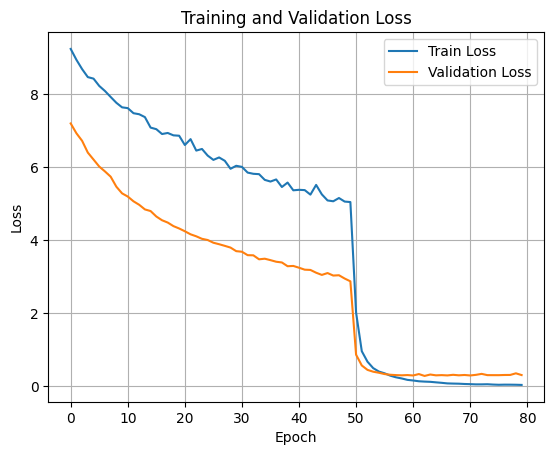

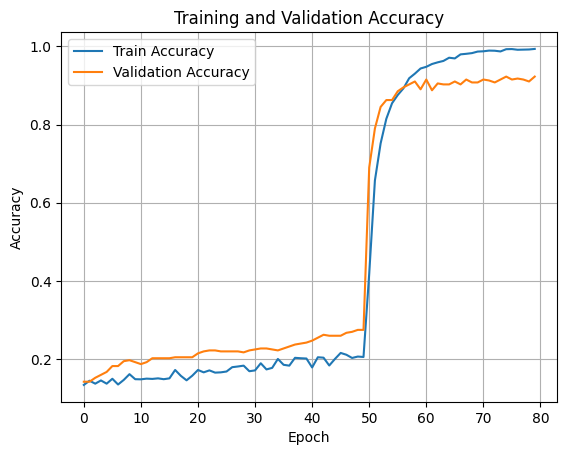

In [45]:
# Append the two histories
train_loss = history_frozen.history['loss'] + history_unfrozen.history['loss']
val_loss = history_frozen.history['val_loss'] + history_unfrozen.history['val_loss']
train_acc = history_frozen.history['accuracy'] + history_unfrozen.history['accuracy']
val_acc = history_frozen.history['val_accuracy'] + history_unfrozen.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [46]:
vgg16_model.evaluate(vgg_test_dataset, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 127ms/step - accuracy: 0.8947 - loss: 0.3705


{'accuracy': 0.9012500047683716, 'loss': 0.3835543692111969}

In [47]:
vgg16_model.save('vgg16_model.keras')

combined_history = {
    'loss': train_loss,
    'val_loss': val_loss,
    'accuracy': train_acc,
    'val_accuracy': val_acc }

with open('vgg16_model_history.json', 'w') as f:
    json.dump(combined_history, f)

In [48]:
vgg16_model = tf.keras.models.load_model('vgg16_model.keras')

with open('vgg16_model_history.json') as f:
    vgg16_model_history = json.load(f)

### Evaluation

Training and Validation Loss

Initial Phase (Epochs 0-~50): Both training and validation loss start relatively high but show a clear decreasing trend. The validation loss is generally lower than the training loss during this phase, suggesting the model is generalizing reasonably well initially, but still underfitting to some extent.

Second Stage (Epochs ~50-100): Around epoch 50, I unfroze more layers of the VGG16 base model and continued training (with a lower learning rate). This is clearly marked by a sharp and rapid decrease in both training and validation loss. The training loss catches up and even goes slightly below the validation loss. The validation loss also reaches a much lower plateau. This indicates that the model is now effectively learning more complex features and adapting the pre-trained weights to the specific Kvasir dataset.

Training and Validation Accuracy

Initial Phase (Epochs 50): Both training and validation accuracy start low and gradually increase. The validation accuracy is consistently higher than the training accuracy, again pointing towards underfitting in the initial stage.

Second Stage (Epochs 30): Corresponding to the drop in loss, there's a significant and rapid increase in both training and validation accuracy around epoch 50. The training accuracy approaches 1.0 (likely indicating it has learned the training data very well), and the validation accuracy reaches a high plateau, close to 0.9. This strong increase confirms that fine-tuning more layers of VGG16 has allowed the model to learn much more effectively.

Accuracy: 0.9012 (or 90.12%) - This is a very high accuracy, indicating that the model correctly classified nearly 90% of the unseen images in the test set.

Loss: 0.384 - This is a low loss value, consistent with a well-performing model that makes accurate predictions with high confidence.

Time:

- Stage 1 Wall Time: 11 minutes 17 seconds
- Stage 2 Wall Time: 7 minutes 17 seconds

## ResNet50

In [12]:
resnet_train_dataset = train_dataset.map(lambda x, y: (resnet.preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)
resnet_val_dataset = val_dataset.map(lambda x, y: (resnet.preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)
resnet_test_dataset = test_dataset.map(lambda x, y: (resnet.preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)

In [13]:
# Load the resnet model, excluding the top layer
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in resnet50_base.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(resnet50_base.output)
x = Dense(128, activation='relu')(x) # Adjusted size based on previous models
x = Dropout(0.4)(x) # Added dropout for regularization
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
resnet50_model = Model(inputs=resnet50_base.input, outputs=output)

# Summary of the resnet50 model
resnet50_model.summary(show_trainable=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_pad         │ (None, 230,     │         0 │ input_layer[0… │   -   │
│ (ZeroPadding2D)   │ 230, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 112,     │     9,472 │ conv1_pad[0][… │   N   │
│ (Conv2D)          │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 112,     │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 112,     │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pad         │ (None, 114,     │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 114, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pool        │ (None, 56, 56,  │         0 │ pool1_pad[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 56, 56,  │     4,160 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 56, 56,  │    36,928 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_c… │ (None, 56, 56,  │    16,640 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_c… │ (None, 56, 56,  │    16,640 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_bn │ (None, 56, 56,  │     1,024 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_bn │ (None, 56, 56,  │     1,024 │ conv2_block1_… │   N 

 Total params: 23,851,016 (90.98 MB)

 Trainable params: 263,304 (1.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# Compile the model
resnet50_model.compile( optimizers.Adam(learning_rate=1e-6), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
%%time
history_frozen_resnet=resnet50_model.fit(resnet_train_dataset,
                                          epochs=100, 
                                          validation_data=resnet_val_dataset, 
                                          verbose=0)

I0000 00:00:1744706392.484237      56 service.cc:145] XLA service 0x7fe834026810 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744706392.484297      56 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1744706399.117520      56 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


CPU times: user 1h 15min 16s, sys: 3min 19s, total: 1h 18min 35s
Wall time: 21min 6s


In [16]:
resnet50_model.evaluate(resnet_test_dataset, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7971 - loss: 0.7180


{'accuracy': 0.78125, 'loss': 0.7138674855232239}

### Second stage of training

In [17]:
# Unfreeze the last few layers for fine-tuning
for layer in resnet50_base.layers[-14:]:
    layer.trainable = True

In [18]:
resnet50_model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_pad         │ (None, 230,     │         0 │ input_layer[0… │   -   │
│ (ZeroPadding2D)   │ 230, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_conv        │ (None, 112,     │     9,472 │ conv1_pad[0][… │   N   │
│ (Conv2D)          │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_bn          │ (None, 112,     │       256 │ conv1_conv[0]… │   N   │
│ (BatchNormalizat… │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv1_relu        │ (None, 112,     │         0 │ conv1_bn[0][0] │   -   │
│ (Activation)      │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pad         │ (None, 114,     │         0 │ conv1_relu[0]… │   -   │
│ (ZeroPadding2D)   │ 114, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ pool1_pool        │ (None, 56, 56,  │         0 │ pool1_pad[0][… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_c… │ (None, 56, 56,  │     4,160 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_1_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_c… │ (None, 56, 56,  │    36,928 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_bn │ (None, 56, 56,  │       256 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_2_r… │ (None, 56, 56,  │         0 │ conv2_block1_… │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_c… │ (None, 56, 56,  │    16,640 │ pool1_pool[0]… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_c… │ (None, 56, 56,  │    16,640 │ conv2_block1_… │   N   │
│ (Conv2D)          │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_0_bn │ (None, 56, 56,  │     1,024 │ conv2_block1_… │   N   │
│ (BatchNormalizat… │ 256)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2_block1_3_bn │ (None, 56, 56,  │     1,024 │ conv2_block1_… │   N 

 Total params: 24,377,626 (92.99 MB)

 Trainable params: 5,783,688 (22.06 MB)

 Non-trainable params: 18,067,328 (68.92 MB)

 Optimizer params: 526,610 (2.01 MB)

In [19]:
# Re-compile the model with a lower learning rate
resnet50_model.compile(optimizers.Adam(learning_rate=1e-7),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [21]:
%%time
# Train the model for another 40 epochs with fine-tuning
history_unfrozen_resnet=resnet50_model.fit(resnet_train_dataset,
                                             epochs=40, 
                                             validation_data=resnet_val_dataset,
                                             verbose=0)

CPU times: user 31min 2s, sys: 1min 39s, total: 32min 42s
Wall time: 8min 48s


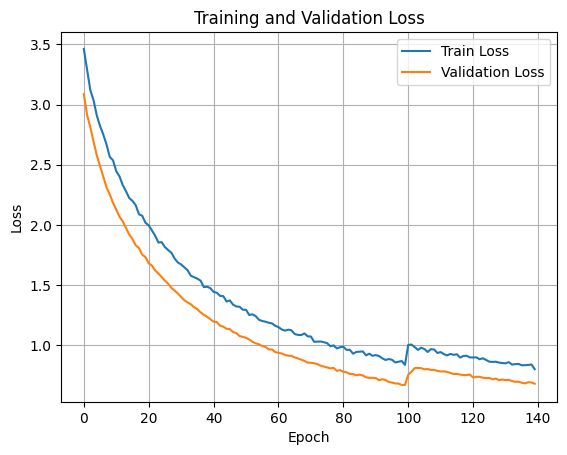

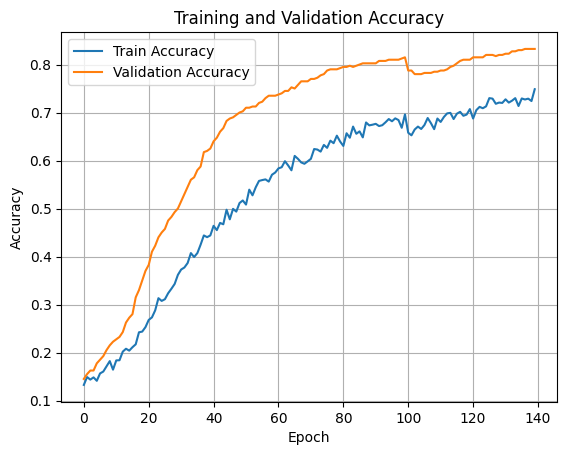

In [22]:
# Append the two histories
train_loss = history_frozen_resnet.history['loss'] + history_unfrozen_resnet.history['loss']
val_loss = history_frozen_resnet.history['val_loss'] + history_unfrozen_resnet.history['val_loss']
train_acc = history_frozen_resnet.history['accuracy'] + history_unfrozen_resnet.history['accuracy']
val_acc = history_frozen_resnet.history['val_accuracy'] + history_unfrozen_resnet.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [23]:
resnet50_model.evaluate(resnet_test_dataset, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.7930 - loss: 0.7421


{'accuracy': 0.8037499785423279, 'loss': 0.7318955063819885}

In [24]:
resnet50_model.save('resnet50_model.keras')

combined_history = {
    'loss': train_loss,
    'val_loss': val_loss,
    'accuracy': train_acc,
    'val_accuracy': val_acc }

with open('resnet50_model_history.json', 'w') as f:
    json.dump(combined_history, f)

In [25]:
resnet50_model = tf.keras.models.load_model('resnet50_model.keras')

with open('resnet50_model_history.json') as f:
    resnet50_model_history = json.load(f)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 434 variables whereas the saved optimizer has 42 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


### Evaluation

Training and Validation Loss

Initial Phase (Epochs 0-~100): Both training and validation loss start at relatively high values and show a decreasing trend. The validation loss is generally lower than the training loss during this phase, suggesting the model is generalizing reasonably well initially, but still underfitting to some extent.

Second Stage (Epochs ~100-140): Around epoch 100, more layers of the ResNet50 base model were unfrozen, and training continued (with a lower learning rate). This is marked by a further decrease in training loss, while the validation loss plateaus and starts to show signs of increasing towards the end.

Training and Validation Accuracy

Initial Phase (Epochs 0-~100): Both training and validation accuracy start low and gradually increase. The validation accuracy is initially higher than the training accuracy. The evaluation after this first stage on a separate dataset yielded an accuracy of approximately 0.7813 and a loss of 0.714.

Second Stage (Epochs ~100-140): Corresponding to the change in loss, there's a noticeable increase in training accuracy. The validation accuracy shows a smaller initial increase but then plateaus around 0.80-0.82 and even shows some slight decline.
Accuracy: 0.8037 (or 80.37%) - This indicates that the model correctly classified approximately 80% of the unseen images in the test set.

Loss: 0.7319 - This is the loss value on the test set.

Time:

Stage 1 Wall Time (100 epochs): 21 minutes 6 seconds

Stage 2 Wall Time (40 epochs): 8 minutes 48 seconds

While it showed improvement in the second stage after unfreezing layers, ResNet50 also exhibited clearer signs of overfitting towards the end of training. The validation loss plateaued and started to increase, while the training accuracy continued to rise significantly. This suggests that ResNet50 might have been more prone to memorizing the training data in the later fine-tuning phase.

The unique architectural element of ResNet50, the residual connections, might have influenced its learning dynamics. While designed to help with training deeper networks, in this transfer learning scenario, they might have contributed to a different rate of adaptation or a different sensitivity to the fine-tuning process compared to VGG16's more sequential architecture.

Comparison to VGG16 Performance:

Comparing the total wall times, the VGG16 model was faster to train across its two fine-tuning stages, taking approximately 18 minutes and 34 seconds, compared to the ResNet50 model, which took approximately 29 minutes and 54 seconds. The ResNet50 model took significantly longer in its first stage.

After the first stage of ResNet50 training (with the base mostly frozen), the model achieved an accuracy of approximately 0.7813 and a loss of 0.714 on a separate evaluation. The subsequent unfreezing and fine-tuning in the second stage led to a final test set accuracy of 80.37% and a loss of 0.7319.

In comparison, the two-stage fine-tuned VGG16 model achieved a higher final test set accuracy of approximately 90.12% with a loss of around 0.384. This indicates that, even after the initial feature extraction phase, the VGG16 architecture appeared to provide more transferable features or adapted more effectively to the Kvasir dataset during fine-tuning, ultimately leading to superior performance over the ResNet50 model under the explored strategies.

## InceptionV3

- Learning rate: Increase from 1e-6 to 1e-4 since we're only training new layers
- Epochs: Reduce from 100 to 20-30 epochs as the top layers typically converge faster
- InceptionV3 is prone to overfitting on smaller datasets, so I've added batch normalization and slightly increased dropout


InceptionV3 has around 311 layers total, and its architecture is organized into inception blocks rather than residual blocks. The last two inception blocks contain approximately 50 layers and are responsible for the highest-level features. The approach of unfreezing specific named blocks ("mixed9" and "mixed10") is generally better than just unfreezing the last N layers because it respects the architectural design of InceptionV3 and ensures the unfreezing of complete functional blocks rather than partial components


In [39]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

# Preprocess datasets for InceptionV3
inception_train_dataset = train_dataset.map(lambda x, y: (preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)
inception_val_dataset = val_dataset.map(lambda x, y: (preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)
inception_test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x * 255), y)).prefetch(tf.data.AUTOTUNE)

In [40]:
# Load the InceptionV3 model, excluding the top layer
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze all layers in the base model
for layer in inception_base.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = GlobalAveragePooling2D()(inception_base.output)
x = Dense(256, activation='relu')(x)  # Slightly larger than before
x = BatchNormalization()(x)  # Add batch normalization
x = Dropout(0.5)(x)  # Slight increase in dropout
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
inception_model = Model(inputs=inception_base.input, outputs=output)

# Summary of the InceptionV3 model
inception_model.summary(show_trainable=True)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1     │ (None, 224,     │         0 │ -              │   -   │
│ (InputLayer)      │ 224, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 111,     │       864 │ input_layer_1… │   N   │
│                   │ 111, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 111,     │        96 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 111, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 111,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 111, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_1 (Conv2D) │ (None, 109,     │     9,216 │ activation[0]… │   N   │
│                   │ 109, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 109,     │        96 │ conv2d_1[0][0] │   N   │
│ (BatchNormalizat… │ 109, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_1      │ (None, 109,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 109, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_2 (Conv2D) │ (None, 109,     │    18,432 │ activation_1[… │   N   │
│                   │ 109, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 109,     │       192 │ conv2d_2[0][0] │   N   │
│ (BatchNormalizat… │ 109, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_2      │ (None, 109,     │         0 │ batch_normali… │   -   │
│ (Activation)      │ 109, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d     │ (None, 54, 54,  │         0 │ activation_2[… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_3 (Conv2D) │ (None, 54, 54,  │     5,120 │ max_pooling2d… │   N   │
│                   │ 80)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 54, 54,  │       240 │ conv2d_3[0][0] │   N   │
│ (BatchNormalizat… │ 80)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_3      │ (None, 54, 54,  │         0 │ batch_normali… │   -   │
│ (Activation)      │ 80)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d_4 (Conv2D) │ (None, 52, 52,  │   138,240 │ activation_3[… │   N   │
│                   │ 192)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 52, 52,  │       576 │ conv2d_4[0][0] │   N   │
│ (BatchNormalizat… │ 192)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_4      │ (None, 52, 52,  │         0 │ batch_normali… │   - 

 Total params: 22,330,408 (85.18 MB)

 Trainable params: 527,112 (2.01 MB)

 Non-trainable params: 21,803,296 (83.17 MB)

In [41]:
# Compile the model with the same optimizer and parameters
inception_model.compile(
    optimizers.Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [42]:
%%time
history_frozen_inception = inception_model.fit(
    inception_train_dataset,
    epochs=30,
    validation_data=inception_val_dataset,
    verbose=0
)

CPU times: user 18min 39s, sys: 48.9 s, total: 19min 28s
Wall time: 5min 23s


In [43]:
inception_model.evaluate(inception_test_dataset, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.8355 - loss: 0.4412


{'accuracy': 0.8550000190734863, 'loss': 0.41122063994407654}

### Second stage of training

In [44]:
# Print the names of the last few layers 
for i, layer in enumerate(inception_base.layers[-60:]):
    print(f"{i+len(inception_base.layers)-60}: {layer.name}")

251: activation_80
252: conv2d_77
253: conv2d_81
254: batch_normalization_77
255: batch_normalization_81
256: activation_77
257: activation_81
258: conv2d_78
259: conv2d_79
260: conv2d_82
261: conv2d_83
262: average_pooling2d_7
263: conv2d_76
264: batch_normalization_78
265: batch_normalization_79
266: batch_normalization_82
267: batch_normalization_83
268: conv2d_84
269: batch_normalization_76
270: activation_78
271: activation_79
272: activation_82
273: activation_83
274: batch_normalization_84
275: activation_76
276: mixed9_0
277: concatenate
278: activation_84
279: mixed9
280: conv2d_89
281: batch_normalization_89
282: activation_89
283: conv2d_86
284: conv2d_90
285: batch_normalization_86
286: batch_normalization_90
287: activation_86
288: activation_90
289: conv2d_87
290: conv2d_88
291: conv2d_91
292: conv2d_92
293: average_pooling2d_8
294: conv2d_85
295: batch_normalization_87
296: batch_normalization_88
297: batch_normalization_91
298: batch_normalization_92
299: conv2d_93
300:

In [45]:
# Unfreeze the final two inception blocks by name
for layer in inception_base.layers:
    if any(name in layer.name for name in ['mixed9', 'mixed10']) or 'mixed9_' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [46]:
# Re-compile the model with a lower learning rate
inception_model.compile(optimizers.Adam(learning_rate=1e-6),
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [47]:
%%time
# Train the model for another 60 epochs with fine-tuning
history_unfrozen_inception=inception_model.fit(inception_train_dataset,
                                             epochs=60, 
                                             validation_data=inception_val_dataset,
                                             verbose=0)

CPU times: user 34min 2s, sys: 2min, total: 36min 2s
Wall time: 14min 9s


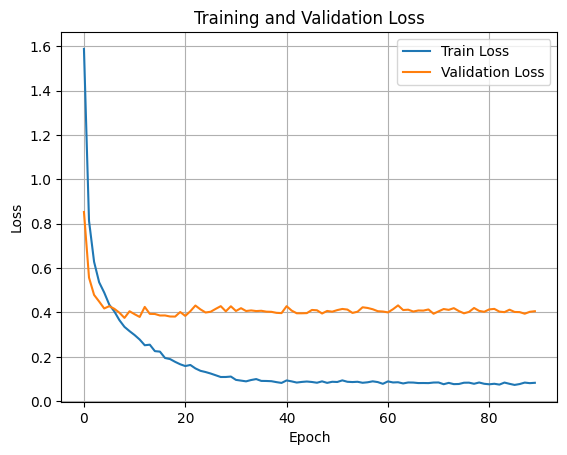

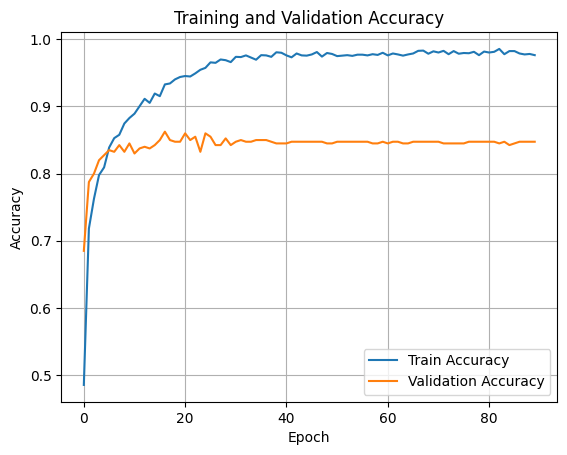

In [48]:
# Append the two histories
train_loss = history_frozen_inception.history['loss'] + history_unfrozen_inception.history['loss']
val_loss = history_frozen_inception.history['val_loss'] + history_unfrozen_inception.history['val_loss']
train_acc = history_frozen_inception.history['accuracy'] + history_unfrozen_inception.history['accuracy']
val_acc = history_frozen_inception.history['val_accuracy'] + history_unfrozen_inception.history['val_accuracy']

# Plot loss
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot accuracy
plt.plot(train_acc, label='Train Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

In [49]:
inception_model.evaluate(inception_test_dataset, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.8571 - loss: 0.4233


{'accuracy': 0.8612499833106995, 'loss': 0.40290310978889465}

In [50]:
inception_model.save('inception_model.keras')

combined_history = {
    'loss': train_loss,
    'val_loss': val_loss,
    'accuracy': train_acc,
    'val_accuracy': val_acc }

with open('inception_model_history.json', 'w') as f:
    json.dump(combined_history, f)

In [51]:
inception_model = tf.keras.models.load_model('inception_model.keras')

with open('inception_model_history.json') as f:
    inception_model_history = json.load(f)

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 390 variables whereas the saved optimizer has 14 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


### Evaluation

* **Training and Validation Loss**
    * **Initial Phase (30 epochs):** The training loss shows a rapid decrease in the initial epochs, reaching a relatively low plateau. The validation loss also decreases quickly and then plateaus at a slightly higher value than the training loss. There's a small gap between the two, suggesting some mild overfitting might be starting.
    * **Second Stage (30-90 epochs):** After around 30 epochs, the training loss continues its gradual decrease, reaching a very low value. The validation loss, however, remains relatively stable, fluctuating within a narrow range, and doesn't show a significant further decrease. This suggests that while the model is continuing to fit the training data, its ability to generalize to the validation data has plateaued, indicating potential overfitting.

* **Training and Validation Accuracy**
    * **Initial Phase (30 epochs):** The training accuracy (teal line) increases rapidly and reaches a high level. The validation accuracy (orange line) also increases significantly but plateaus at a slightly lower level than the training accuracy.
    * **Second Stage (0-90 epochs):** The training accuracy continues its upward trend, approaching very high values. The validation accuracy, however, plateaus and doesn't show a substantial further increase, remaining below the training accuracy. This further reinforces the idea of overfitting in the later stages.

**Evaluation Results:**

* **Stage 1 (30 epochs):**
    * **Accuracy:** 0.8550
    * **Loss:** 0.4112
    * **Wall time:** 5 minutes 23 seconds

* **Stage 2 (60 epochs):**
    * **Accuracy:** 0.8612
    * **Loss:** 0.4029
    * **Wall time:** 14 minutes 9 seconds

**Interpretation and Analysis:**

1.  **Good Initial Learning:** Stage 1 shows good initial learning, with a high validation accuracy achieved after only 30 epochs. This indicates that the features learned by InceptionV3 are quite transferable to the Kvasir dataset.

2.  **Limited Improvement in Stage 2:** The improvement in validation accuracy from Stage 1 to Stage 2 is relatively small (from 0.8550 to what we can infer from the graph to be around 0.85-0.86). However, the training accuracy continues to increase significantly, and the training loss decreases further. This is a classic sign of **overfitting**. The model is learning the specifics of the training data but not generalizing much better to unseen data.

3.  **Computational Cost:** Stage 2 took significantly longer (14 minutes 9 seconds) than Stage 1 (5 minutes 23 seconds), yielding only a marginal improvement in validation performance.

**Comparison to VGG16 and ResNet50:**

* The peak validation accuracy achieved by this InceptionV3 model (around 0.85-0.86) appears to be lower than the peak validation accuracy observed with the two-stage fine-tuned VGG16 model (around 0.90).
* It's also in the same ballpark as or slightly better than the peak validation accuracy with ResNet50 (around 0.80-0.82) before it started to overfit more significantly.
* The final test accuracy of InceptionV3 (0.8612) falls between the final test accuracies of ResNet50 (0.8037) and VGG16 (around 0.90).

**Notes on Unique Behaviors of InceptionV3:**

* **Relatively Fast Initial Learning:** InceptionV3 seemed to reach a reasonably high validation accuracy quickly in the first stage with only the top layers trained.
* **Plateauing of Validation Performance:** Unlike VGG16 which showed a substantial jump in validation accuracy in its second stage, InceptionV3's validation performance plateaued relatively early after unfreezing more layers. This suggests that the initial features extracted by the frozen InceptionV3 base might have already captured the most relevant information for the task, and further fine-tuning didn't lead to significant improvements in generalization.
* **Efficiency:** The wall time for the initial feature extraction stage was quite efficient compared to ResNet50.

**Improvements for InceptionV3:**

1.  **Early Stopping:** Implement early stopping based on the validation accuracy to prevent overfitting and save the model at its best generalizing point.
2.  **Hyperparameter Tuning:** Experiment with the size of the dense layer, dropout rate, and the number of InceptionV3 layers unfrozen in Stage 2. A more conservative approach to unfreezing might be beneficial.
3.  **Learning Rate:** Carefully tune the learning rate for both stages. A smaller learning rate in Stage 2 might help in finer adjustments without causing significant overfitting.

In conclusion, while InceptionV3 shows good initial promise with fast learning, the two-stage fine-tuning strategy in this case didn't yield as substantial an improvement as it did for VGG16, and the model exhibited a tendency to overfit. Careful hyperparameter tuning and early stopping are crucial for optimizing its performance.